In [1]:
!pip install seaborn pandas scipy scikit-learn dask[complete]
!python3 -m pip install --upgrade pip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
import seaborn as sns
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

2024-02-20 18:20:34.863182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 18:20:34.863212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 18:20:34.864078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 18:20:34.869287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_dir = pathlib.Path('data').with_suffix('')

In [4]:
data = 'data'

paths = [path.parts[-2:] for path in
         pathlib.Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df                                                            #display dataframe

,Class,Images
0,Cellulitis,Cellulities47.jpg
1,Cellulitis,Cellulities25.jpg
2,Cellulitis,Cellulities7.jpg
3,Cellulitis,Cellulities18.jpg
4,Cellulitis,Cellulities15.jpg
...,...,...
495,Vitiligo,vitiligo25.jpg
496,Vitiligo,vitiligo39.jpg
497,Vitiligo,vitiligo11.jpg
498,Vitiligo,vitiligo33.jpg


In [5]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df.Images)))
print("Class Count : {} \n".format(len(df['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 500
Class Count : 10 

Count the number of images in each class
Class
Cellulitis    50
Chickenpox    50
Dermatitis    50
Eczema        50
Hives         50
Lupus         50
Melanoma      50
Psoriasis     50
Ringworm      50
Vitiligo      50
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

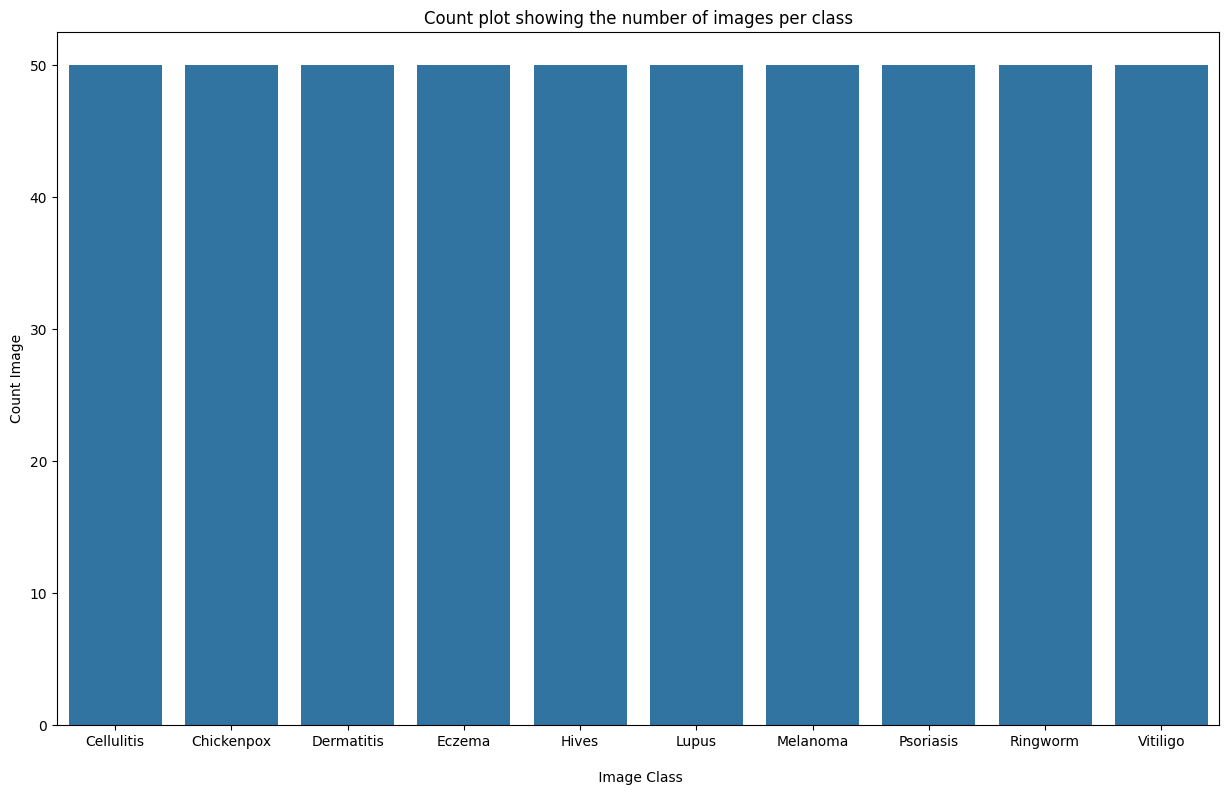

In [6]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Count plot showing the number of images per class')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

We have a good distribution of images, no over- or underepresentation of any of the classes.

In [7]:
image_count = len(list(data_dir.glob('*/*.jpeg')))+len(list(data_dir.glob('*/*.jpg')))+len(list(data_dir.glob('*/*.png'))) # folder/name <- */*
print(image_count)

500


In [8]:
directories = {'Cellulitis': 'data/Cellulitis/',
               'Chickenpox': 'data/Chickenpox/',
               'Dermatitis': 'data/Dermatitis/',
               'Eczema': 'data/Eczema/',
               'Hives': 'data/Hives/',
               'Lupus': 'data/Lupus/',
               'Melanoma': 'data/Melanoma/',
               'Psoriasis': 'data/Psoriasis/',
               'Ringworm': 'data/Ringworm/',
               'Vitiligo': 'data/Vitiligo/'
              }

def get_dims(file):
  im = Image.open(file)
  
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

def get_rgb(file):
    im = Image.open(file)
    arr = np.array(im)
    r_mean = np.mean(arr[:,:,0])
    g_mean = np.mean(arr[:,:,1])
    b_mean = np.mean(arr[:,:,2])
    bright_mean = np.mean([r_mean, g_mean, b_mean])
    return r_mean, g_mean, b_mean, bright_mean

[########################################] | 100% Completed | 506.59 ms
[########################################] | 100% Completed | 608.69 ms
[########################################] | 100% Completed | 608.96 ms
[########################################] | 100% Completed | 608.30 ms
[########################################] | 100% Completed | 608.45 ms
[########################################] | 100% Completed | 608.65 ms
[########################################] | 100% Completed | 606.86 ms
[########################################] | 100% Completed | 608.12 ms
[########################################] | 100% Completed | 605.55 ms
[########################################] | 100% Completed | 608.17 ms


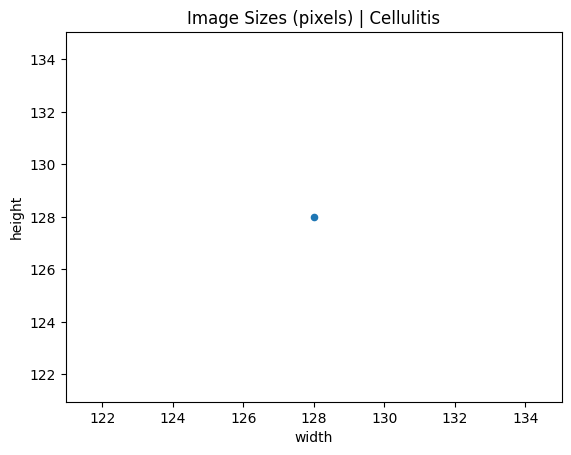

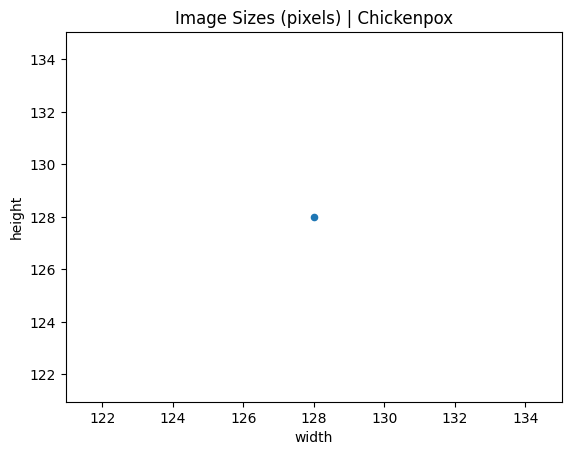

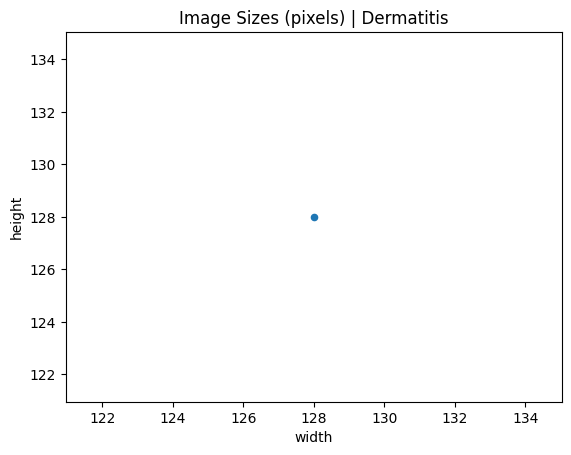

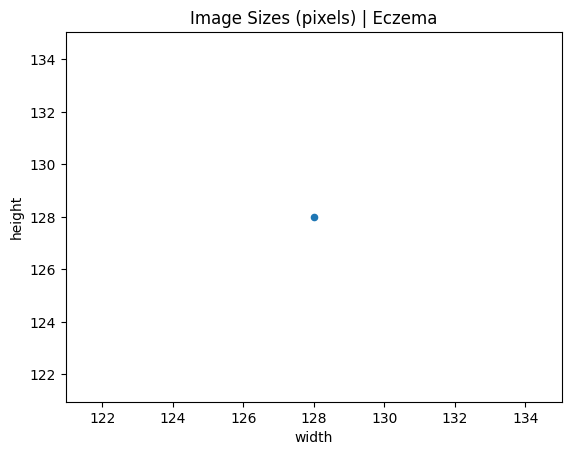

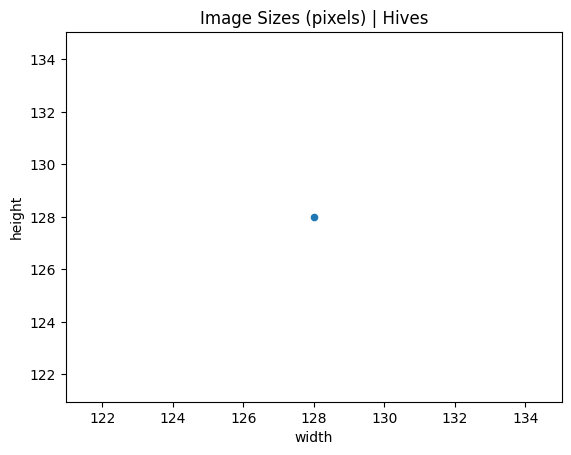

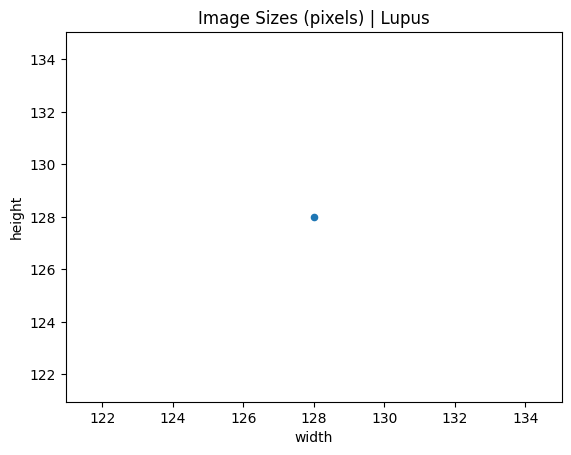

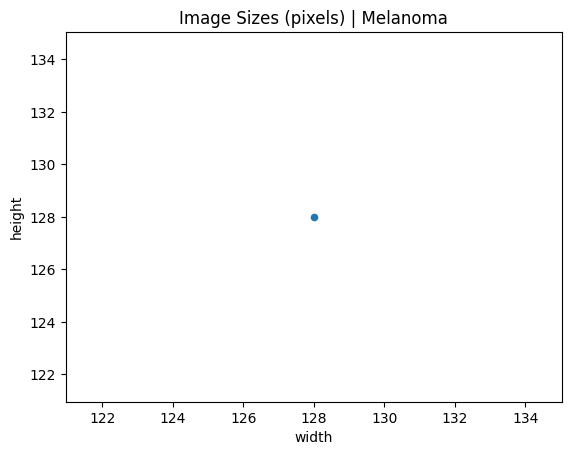

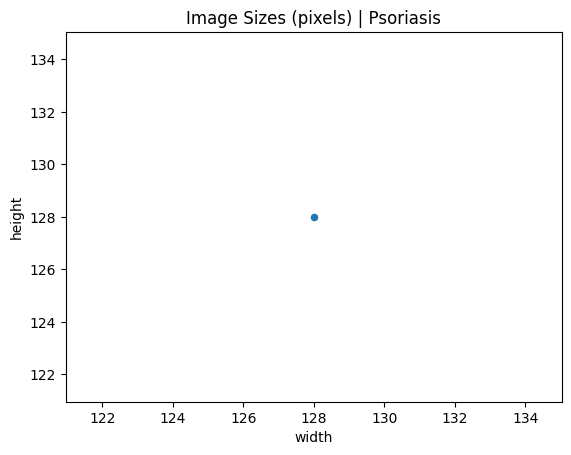

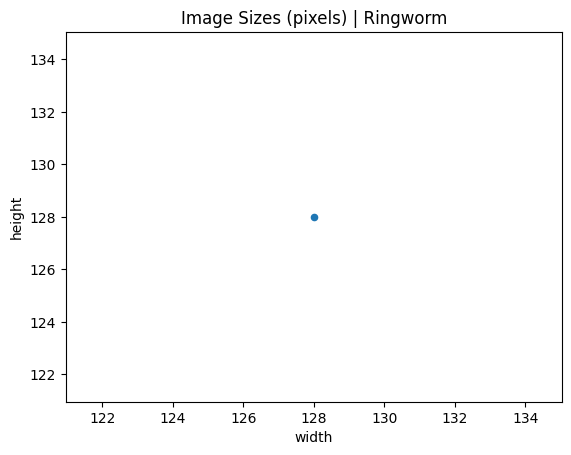

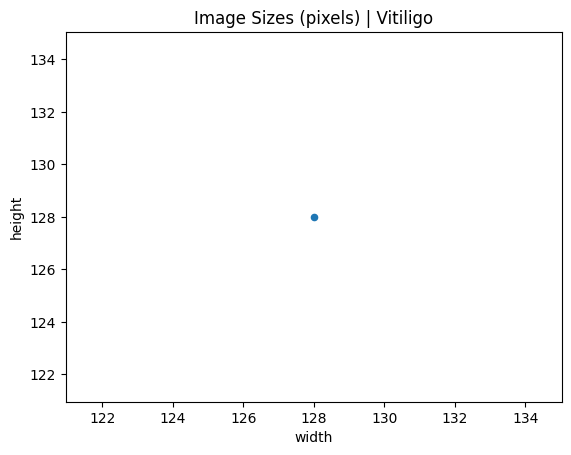

In [9]:
import os
import dask.bag as db
import dask.array as da
from dask.diagnostics import ProgressBar
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = db.from_sequence(filelist).map(get_dims)
    
  with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

<Axes: xlabel='Brightness', ylabel='Count'>

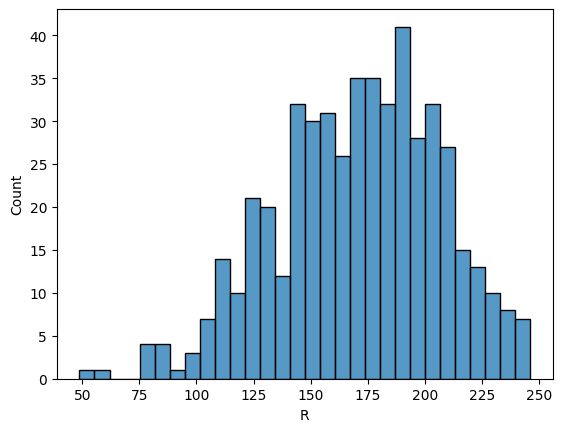

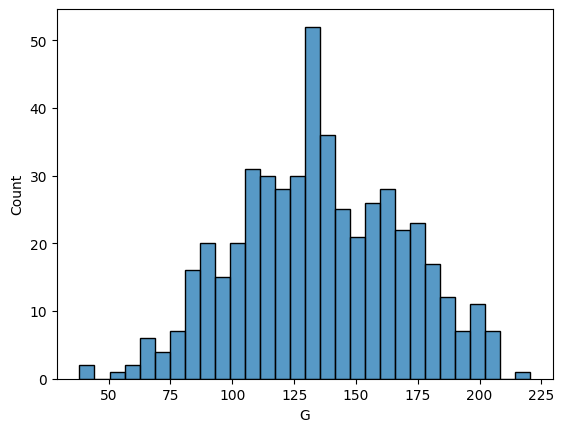

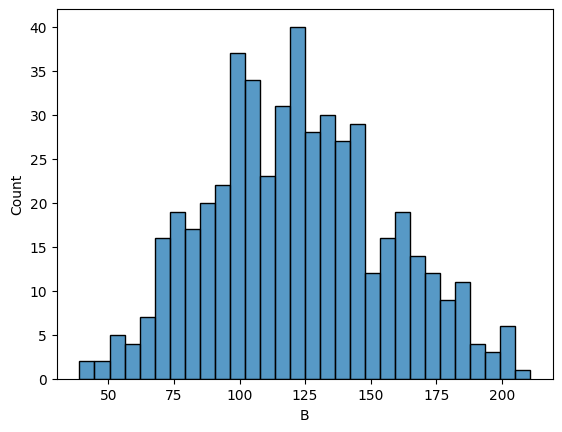

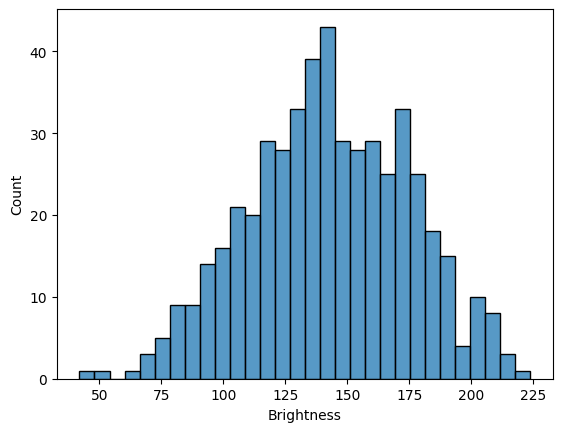

In [10]:
filelist=[]
for n,d in directories.items():
  filepath = d
  filelist+=[filepath + f for f in os.listdir(filepath)]

r_array=[]
g_array=[]
b_array=[]
bright_array=[]
for file in filelist:
    rm, gm, bm, brm = get_rgb(file)
    r_array.append(rm)
    g_array.append(gm)
    b_array.append(bm)
    bright_array.append(brm)


rgbb_df=pd.DataFrame({ 'R':r_array,
                       'G':g_array,
                       'B':b_array,
                       'Brightness':bright_array})
fig1 = plt.figure()
sns.histplot(data=rgbb_df, x = 'R',  bins=30)
fig2 = plt.figure()
sns.histplot(data=rgbb_df, x = 'G',  bins=30)
fig3=plt.figure()
sns.histplot(data=rgbb_df, x = 'B',  bins=30)
fig4=plt.figure()
sns.histplot(data=rgbb_df, x = 'Brightness',  bins=30)


In [11]:
rgbb_df.describe()

,R,G,B,Brightness
count,500.000000,500.000000,500.000000,500.000000
mean,170.673382,135.100986,121.972157,142.582175
std,35.897274,33.441566,33.724103,32.528924
min,48.740723,38.195129,38.954407,41.963420
25%,146.797058,111.188782,97.990891,119.864680
50%,173.406921,133.711243,120.664001,141.673299
75%,197.024979,160.949310,144.019424,167.846166
max,246.294189,220.514832,210.917542,223.816264


In [12]:
rgbb_df.skew()

R            -0.337419
G            -0.012611
B             0.180986
Brightness   -0.083943
dtype: float64

In [13]:
rgbb_df.kurtosis()

R            -0.161689
G            -0.453410
B            -0.428477
Brightness   -0.351129
dtype: float64

In [14]:
#We have to resize the images, not all of them are at 128 x 128 - rerun this file afterwards
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  for file in filelist:
      im = Image.open(file)
      im = im.resize((128,128))
      im = im.convert('RGB')
      
      im.save(file)

Let's check out the original data set, prior to resizing:

In [15]:
data_dir_ini = pathlib.Path('data_ini').with_suffix('')

In [16]:
data_ini = 'data'

paths_ini = [path.parts[-2:] for path in
         pathlib.Path(data_ini).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df_ini = pd.DataFrame(data=paths_ini, columns=['Class','Images'])     #create column names for dataframe
df_ini = df_ini.sort_values('Class',ascending=True)                   #sort class name
df_ini.reset_index(drop=True, inplace=True)                       #sort index of each row
df_ini                                                            #display dataframe

,Class,Images
0,Cellulitis,Cellulities47.jpg
1,Cellulitis,Cellulities25.jpg
2,Cellulitis,Cellulities7.jpg
3,Cellulitis,Cellulities18.jpg
4,Cellulitis,Cellulities15.jpg
...,...,...
495,Vitiligo,vitiligo25.jpg
496,Vitiligo,vitiligo39.jpg
497,Vitiligo,vitiligo11.jpg
498,Vitiligo,vitiligo33.jpg


In [17]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df_ini.Images)))
print("Class Count : {} \n".format(len(df_ini['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 500
Class Count : 10 

Count the number of images in each class
Class
Cellulitis    50
Chickenpox    50
Dermatitis    50
Eczema        50
Hives         50
Lupus         50
Melanoma      50
Psoriasis     50
Ringworm      50
Vitiligo      50
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

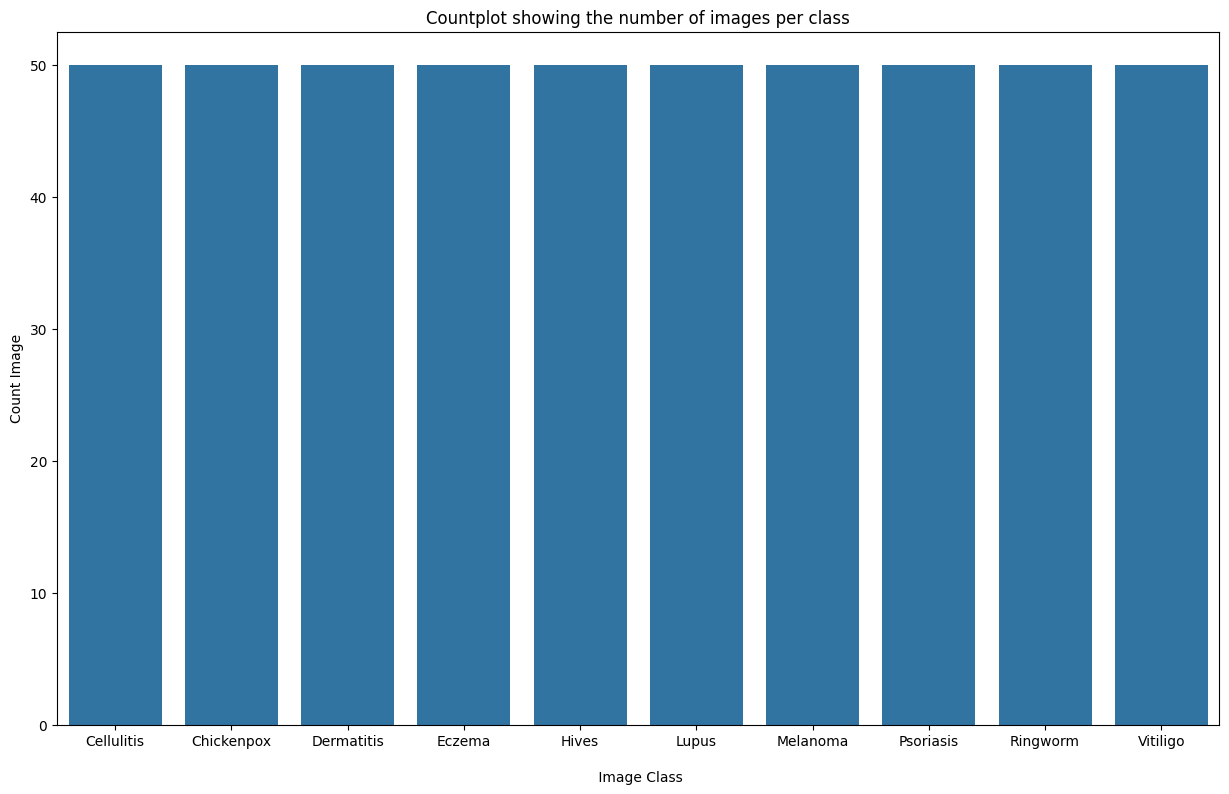

In [18]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Countplot showing the number of images per class')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

[########################################] | 100% Completed | 608.65 ms
[########################################] | 100% Completed | 607.37 ms
[########################################] | 100% Completed | 608.19 ms
[########################################] | 100% Completed | 611.19 ms
[########################################] | 100% Completed | 607.40 ms
[########################################] | 100% Completed | 608.15 ms
[########################################] | 100% Completed | 608.38 ms
[########################################] | 100% Completed | 608.01 ms
[########################################] | 100% Completed | 609.15 ms
[########################################] | 100% Completed | 507.60 ms


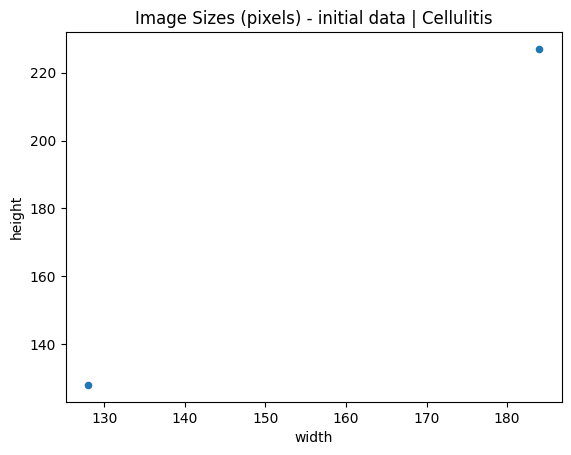

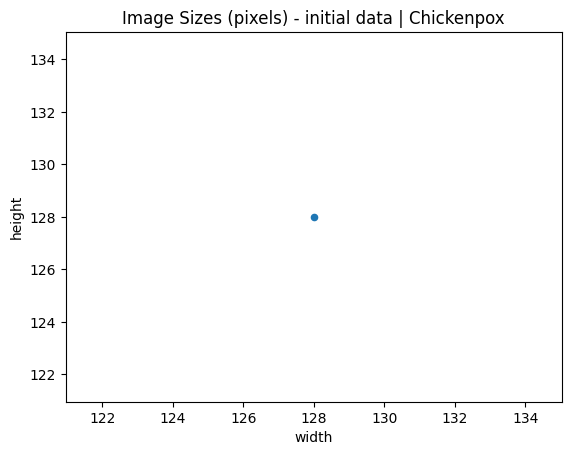

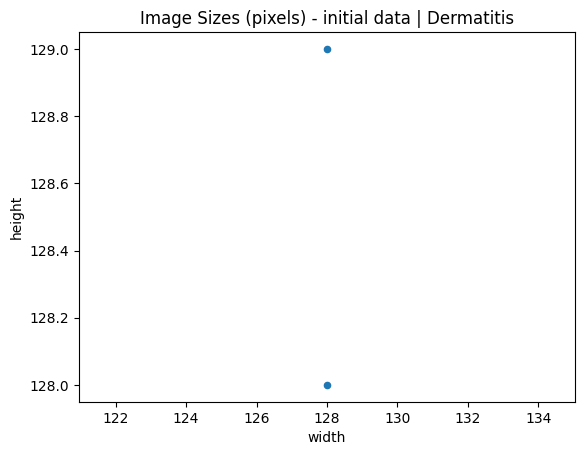

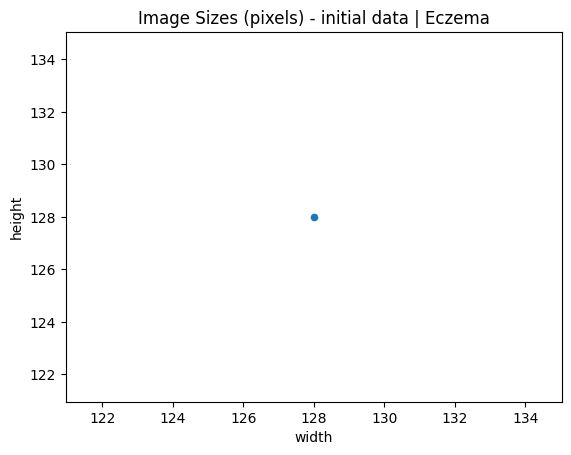

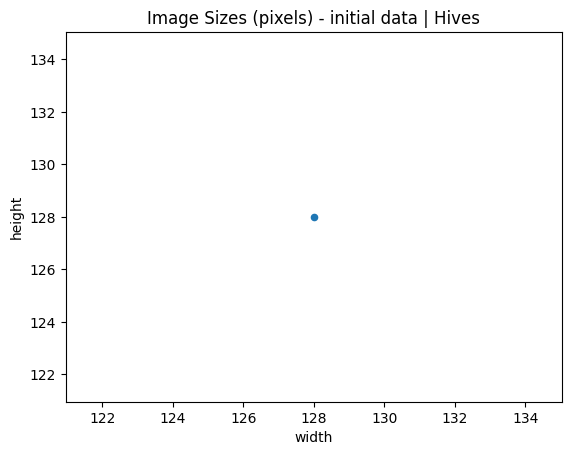

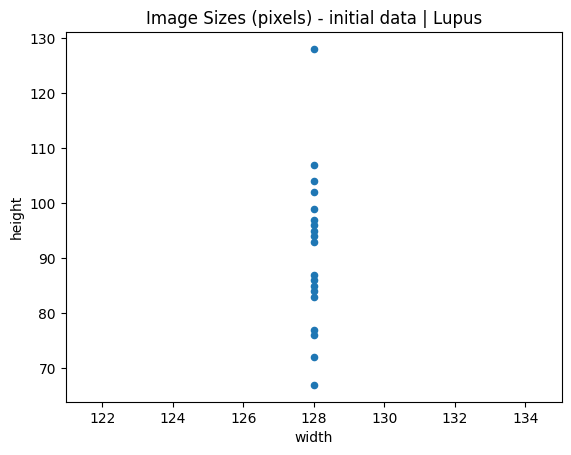

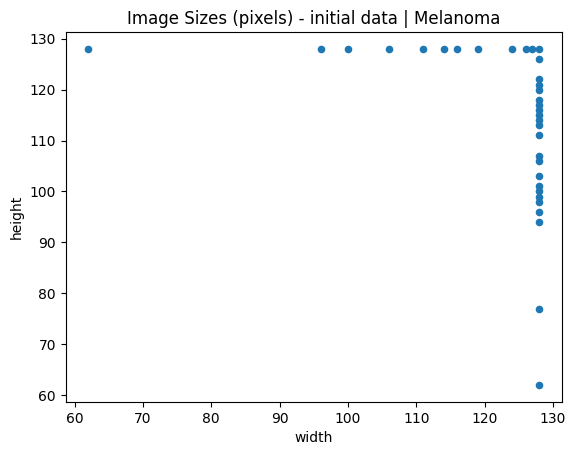

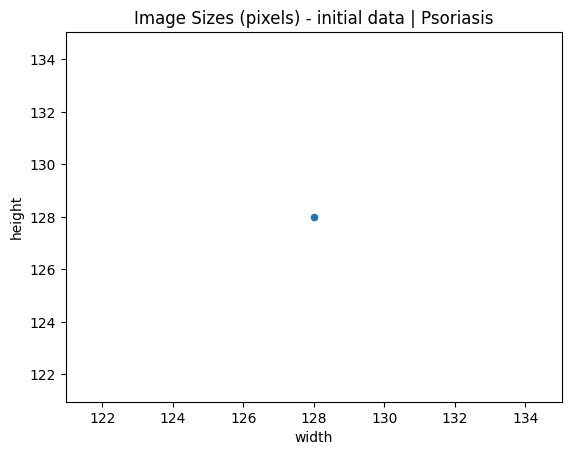

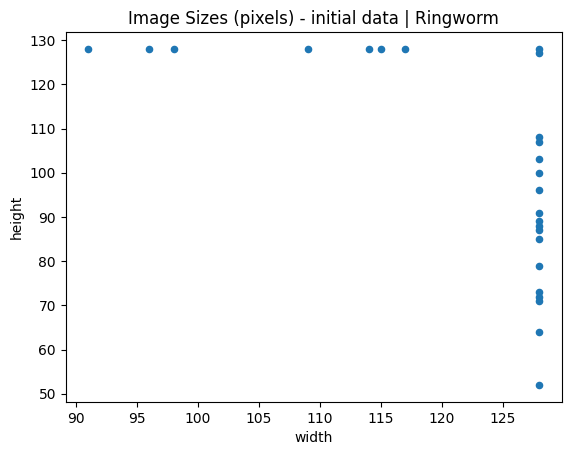

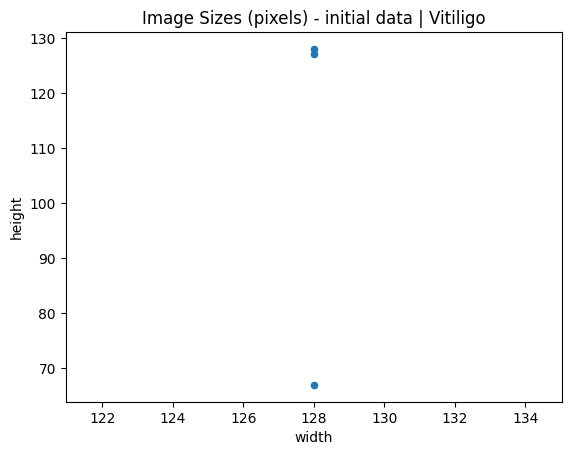

In [19]:
directories_ini = {'Cellulitis': 'data_ini/Cellulitis/',
               'Chickenpox': 'data_ini/Chickenpox/',
               'Dermatitis': 'data_ini/Dermatitis/',
               'Eczema': 'data_ini/Eczema/',
               'Hives': 'data_ini/Hives/',
               'Lupus': 'data_ini/Lupus/',
               'Melanoma': 'data_ini/Melanoma/',
               'Psoriasis': 'data_ini/Psoriasis/',
               'Ringworm': 'data_ini/Ringworm/',
               'Vitiligo': 'data_ini/Vitiligo/'
              }

for n,d in directories_ini.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims_ini = db.from_sequence(filelist).map(get_dims)
    
  with ProgressBar():
    dims_ini = dims_ini.compute()
    dim_df_ini = pd.DataFrame(dims_ini, columns=['height', 'width'])
    sizes_ini = dim_df_ini.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes_ini.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) - initial data | {}'.format(n))

<Axes: xlabel='Brightness', ylabel='Count'>

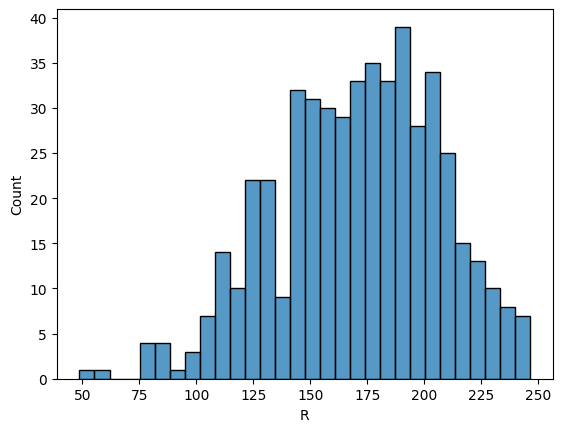

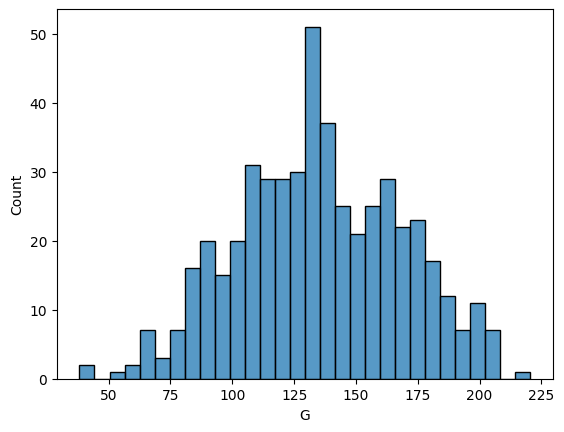

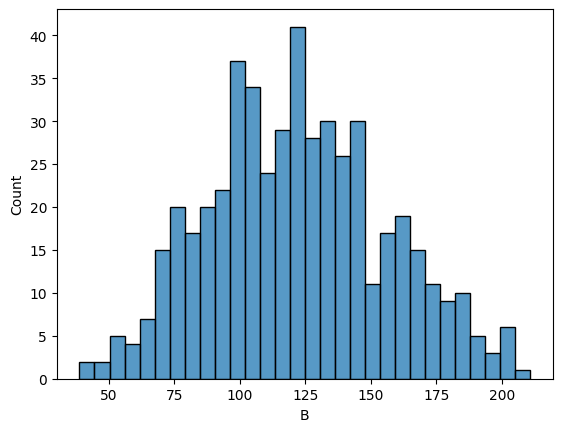

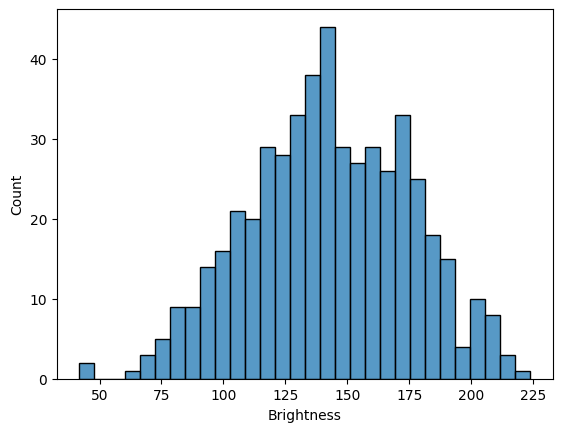

In [20]:
filelist=[]
for n,d in directories_ini.items():
  filepath = d
  filelist+=[filepath + f for f in os.listdir(filepath)]

r_array=[]
g_array=[]
b_array=[]
bright_array=[]
for file in filelist:
    rm, gm, bm, brm = get_rgb(file)
    r_array.append(rm)
    g_array.append(gm)
    b_array.append(bm)
    bright_array.append(brm)


rgbb_df_ini=pd.DataFrame({ 'R':r_array,
                       'G':g_array,
                       'B':b_array,
                       'Brightness':bright_array})
fig1 = plt.figure()
sns.histplot(data=rgbb_df_ini, x = 'R',  bins=30)
fig2 = plt.figure()
sns.histplot(data=rgbb_df_ini, x = 'G',  bins=30)
fig3=plt.figure()
sns.histplot(data=rgbb_df_ini, x = 'B',  bins=30)
fig4=plt.figure()
sns.histplot(data=rgbb_df_ini, x = 'Brightness',  bins=30)

Let's begin looking at some deep learning models.

In [21]:
batch_size = 16
img_height = 128
img_width = 128

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 450 files for training.


2024-02-20 18:20:55.270934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 18:20:55.275351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 18:20:55.275532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Let's take a look at some sample images

In [23]:
class_names = train_ds.class_names
print(class_names)

['Cellulitis', 'Chickenpox', 'Dermatitis', 'Eczema', 'Hives', 'Lupus', 'Melanoma', 'Psoriasis', 'Ringworm', 'Vitiligo']


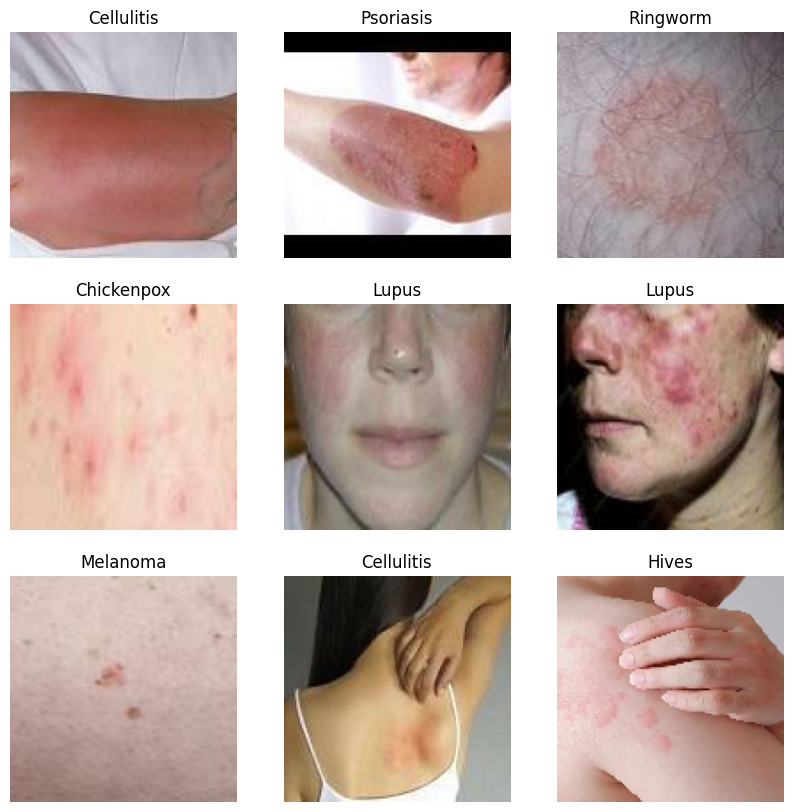

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(  #the tf terminology for this method demands the term validation where we we might otherwise use the term test. Just know that validation in this case means test, we're not doing a 3-way split of the data nor k-fold cross-validation
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 50 files for validation.


Let's see if we have all the classes represented in both the training and the test set.

In [26]:
#class_names_train = train_ds.class_names
#print(class_names_train)

In [27]:
#class_names_test = val_ds.class_names
#print(class_names_test)

In [28]:
#Scaling the data - part of EDA
normalization_layer = layers.Rescaling(1./255)

In [29]:
#begin with a custom Keras model, as per the tutorial on the tensorflow website pertaining to image classification:
num_classes = 10

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [31]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-20 18:20:57.211850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-20 18:20:57.931536: I external/local_xla/xla/service/service.cc:168] XLA service 0xc229350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 18:20:57.931555: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-20 18:20:57.936301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708453257.997420  267465 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - 6s 70ms/step - loss: 2.2440 - accuracy: 0.1356 - val_loss: 1.9629 - val_accuracy: 0.2000
Epoch 2/50
29/29 [==============================] - 1s 17ms/step - loss: 1.9402 - accuracy: 0.2911 - val_loss: 2.0442 - val_accuracy: 0.3600
Epoch 3/50
29/29 [==============================] - 1s 17ms/step - loss: 1.8714 - accuracy: 0.3133 - val_loss: 1.8263 - val_accuracy: 0.3000
Epoch 4/50
29/29 [==============================] - 1s 17ms/step - loss: 1.6050 - accuracy: 0.4444 - val_loss: 1.5740 - val_accuracy: 0.4200
Epoch 5/50
29/29 [==============================] - 1s 17ms/step - loss: 1.3164 - accuracy: 0.5444 - val_loss: 1.8098 - val_accuracy: 0.4600
Epoch 6/50
29/29 [==============================] - 1s 17ms/step - loss: 1.1085 - accuracy: 0.6222 - val_loss: 1.8868 - val_accuracy: 0.4400
Epoch 7/50
29/29 [==============================] - 0s 17ms/step - loss: 0.8607 - accuracy: 0.7156 - val_loss: 3.7059 - val_accuracy: 0.3800
Epoch 8/50
29/29 [======

In [32]:
#hist = model.fit_generator(steps_per_epoch=10,generator=train_ds, validation_data= val_ds,epochs=20)

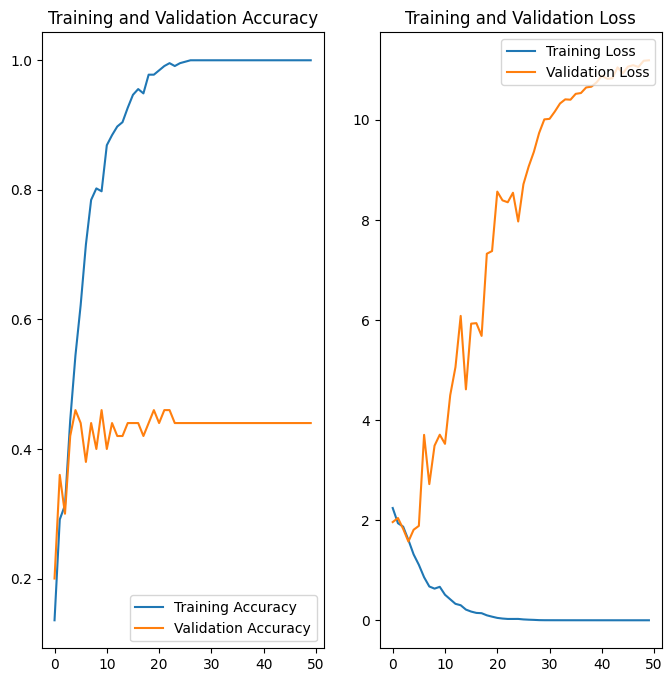

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's see how we can tune this model for better performance. We will first introduce an augmentation layer, then introduce dropout layers as well and lower the learning rate.

In [34]:
img_height = 128
img_width = 128
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    #layers.RandomZoom(0.1),
  ]
)

In [35]:
#plt.figure(figsize=(10, 10))
#for images, _ in train_ds.take(1):
#  for i in range(9):
#    augmented_images = data_augmentation(images)
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(augmented_images[0].numpy().astype("uint8"))
#    plt.axis("off")

In [36]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [37]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                 

In [38]:
epochs = 50
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-20 18:21:28.628513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29/29 [==============================] - 6s 63ms/step - loss: 2.3146 - accuracy: 0.1333 - val_loss: 2.1428 - val_accuracy: 0.2200
Epoch 2/50
29/29 [==============================] - 1s 22ms/step - loss: 2.0875 - accuracy: 0.2156 - val_loss: 1.9132 - val_accuracy: 0.3000
Epoch 3/50
29/29 [==============================] - 1s 22ms/step - loss: 1.8745 - accuracy: 0.3333 - val_loss: 1.9414 - val_accuracy: 0.2600
Epoch 4/50
29/29 [==============================] - 1s 22ms/step - loss: 1.7889 - accuracy: 0.3578 - val_loss: 1.7625 - val_accuracy: 0.3800
Epoch 5/50
29/29 [==============================] - 1s 22ms/step - loss: 1.8027 - accuracy: 0.3667 - val_loss: 1.7885 - val_accuracy: 0.4400
Epoch 6/50
29/29 [==============================] - 1s 22ms/step - loss: 1.7086 - accuracy: 0.3978 - val_loss: 1.7492 - val_accuracy: 0.4200
Epoch 7/50
29/29 [==============================] - 1s 22ms/step - loss: 1.6053 - accuracy: 0.4400 - val_loss: 1.7608 - val_accuracy: 0.4200
Epoch 8/50
29/29 [======

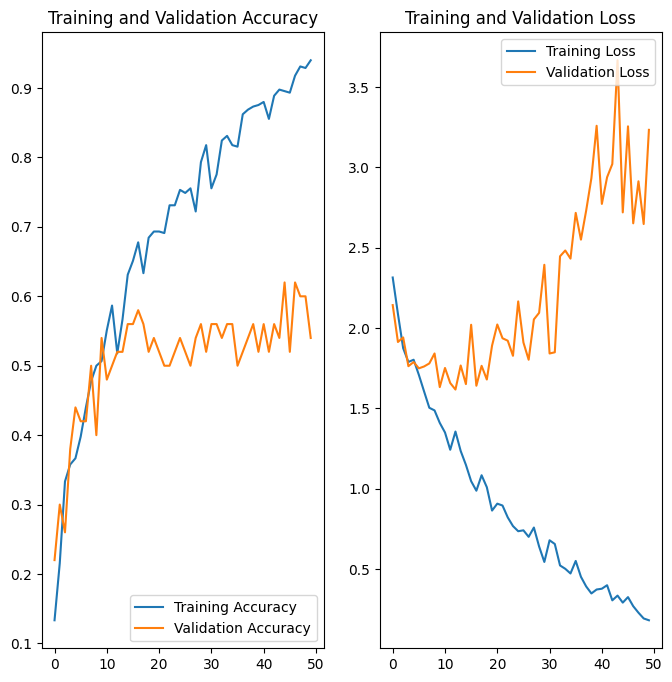

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's check out AlexNet next:

In [40]:
model_alexnet=keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])


In [41]:
model_alexnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']    
)
model_alexnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 30, 30, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 15, 15, 256)      

In [42]:
history_alexnet=model_alexnet.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    validation_freq=1
)

Epoch 1/50
29/29 [==============================] - 9s 106ms/step - loss: 3.7951 - accuracy: 0.1622 - val_loss: 8.1633 - val_accuracy: 0.1200
Epoch 2/50
29/29 [==============================] - 1s 27ms/step - loss: 2.7730 - accuracy: 0.2289 - val_loss: 2.6816 - val_accuracy: 0.1800
Epoch 3/50
29/29 [==============================] - 1s 28ms/step - loss: 2.2753 - accuracy: 0.2978 - val_loss: 2.3127 - val_accuracy: 0.1600
Epoch 4/50
29/29 [==============================] - 1s 28ms/step - loss: 2.0170 - accuracy: 0.3444 - val_loss: 1.9240 - val_accuracy: 0.2400
Epoch 5/50
29/29 [==============================] - 1s 28ms/step - loss: 1.9369 - accuracy: 0.3889 - val_loss: 2.1334 - val_accuracy: 0.1600
Epoch 6/50
29/29 [==============================] - 1s 27ms/step - loss: 1.7993 - accuracy: 0.3911 - val_loss: 1.7174 - val_accuracy: 0.4400
Epoch 7/50
29/29 [==============================] - 1s 27ms/step - loss: 1.6931 - accuracy: 0.4467 - val_loss: 1.9789 - val_accuracy: 0.3000
Epoch 8/50
2

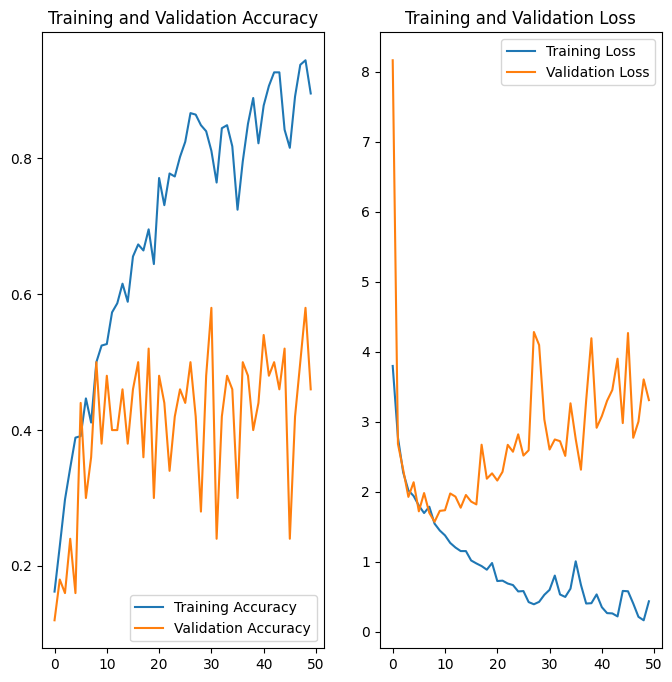

In [43]:
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']

loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's take another look at AlexNet, now after some tuning. We already had dropout layers, now we've introduced augmentation and lowered the learning rate.

In [44]:
model_alexnet2=keras.models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

In [45]:
model_alexnet2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']    
)
model_alexnet2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 128)       46592     
                                                                 
 batch_normalization_5 (Bat  (None, 30, 30, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 15, 256)      

In [46]:
history_alexnet2=model_alexnet2.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    validation_freq=1
)

Epoch 1/100
29/29 [==============================] - 3s 33ms/step - loss: 3.8177 - accuracy: 0.1556 - val_loss: 8.8961 - val_accuracy: 0.1200
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 2.9571 - accuracy: 0.1978 - val_loss: 4.4389 - val_accuracy: 0.1200
Epoch 3/100
29/29 [==============================] - 1s 30ms/step - loss: 2.2534 - accuracy: 0.2822 - val_loss: 2.3351 - val_accuracy: 0.2800
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 2.2473 - accuracy: 0.2711 - val_loss: 1.9593 - val_accuracy: 0.4000
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 2.0970 - accuracy: 0.3089 - val_loss: 1.8622 - val_accuracy: 0.3000
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 1.9524 - accuracy: 0.3422 - val_loss: 1.8266 - val_accuracy: 0.3600
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 1.8955 - accuracy: 0.3444 - val_loss: 1.8377 - val_accuracy: 0.4200
Epoch 

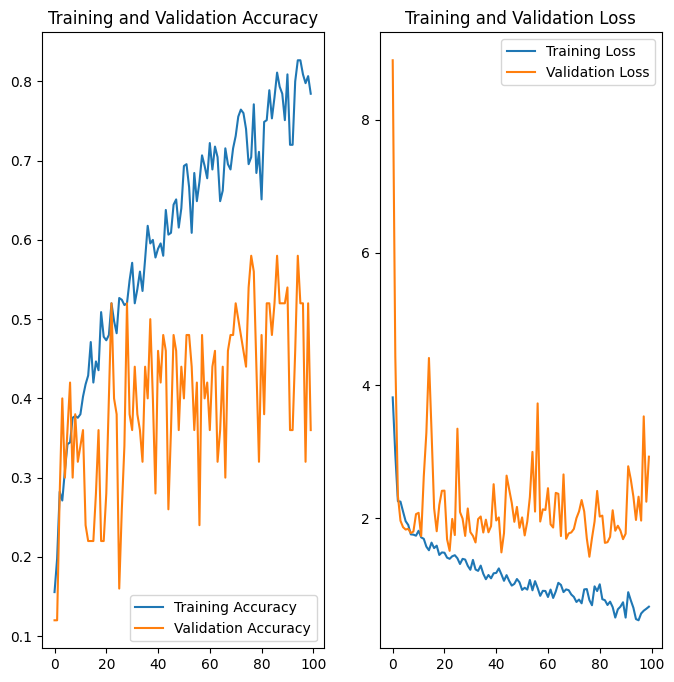

In [47]:
epochs=100
acc = history_alexnet2.history['accuracy']
val_acc = history_alexnet2.history['val_accuracy']

loss = history_alexnet2.history['loss']
val_loss = history_alexnet2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's give VGG a try. We'll be using the keras applications for VGG16 and VGG19.

In [48]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np


In [49]:


train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                    # validation_split=0.15,
                                    #fill_mode = 'constant',
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing


In [50]:
BATCH_SIZE=16

train_data_dir = 'skind_training'
test_data_dir = 'skind_validation'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               
                                               
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

testgen = train_generator.flow_from_directory(test_data_dir,
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)




Found 450 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [51]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [52]:
input_shape = (128, 128, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_test_steps = testgen.samples // BATCH_SIZE
n_epochs = 200

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)
vgg_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [53]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=testgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_test_steps,
                            
                            verbose=1)


Epoch 1/200
28/28 [==============================] - 11s 184ms/step - loss: 3.3644 - accuracy: 0.1521 - val_loss: 1.9966 - val_accuracy: 0.2500
Epoch 2/200
28/28 [==============================] - 3s 114ms/step - loss: 2.1903 - accuracy: 0.1935 - val_loss: 2.1169 - val_accuracy: 0.1458
Epoch 3/200
28/28 [==============================] - 3s 114ms/step - loss: 2.2097 - accuracy: 0.2051 - val_loss: 2.0486 - val_accuracy: 0.3333
Epoch 4/200
28/28 [==============================] - 3s 116ms/step - loss: 2.0522 - accuracy: 0.2258 - val_loss: 1.8871 - val_accuracy: 0.3750
Epoch 5/200
28/28 [==============================] - 3s 114ms/step - loss: 2.0688 - accuracy: 0.2166 - val_loss: 1.8546 - val_accuracy: 0.3542
Epoch 6/200
28/28 [==============================] - 3s 114ms/step - loss: 2.0222 - accuracy: 0.2581 - val_loss: 1.9440 - val_accuracy: 0.3125
Epoch 7/200
28/28 [==============================] - 3s 115ms/step - loss: 2.0097 - accuracy: 0.2742 - val_loss: 1.8671 - val_accuracy: 0.375

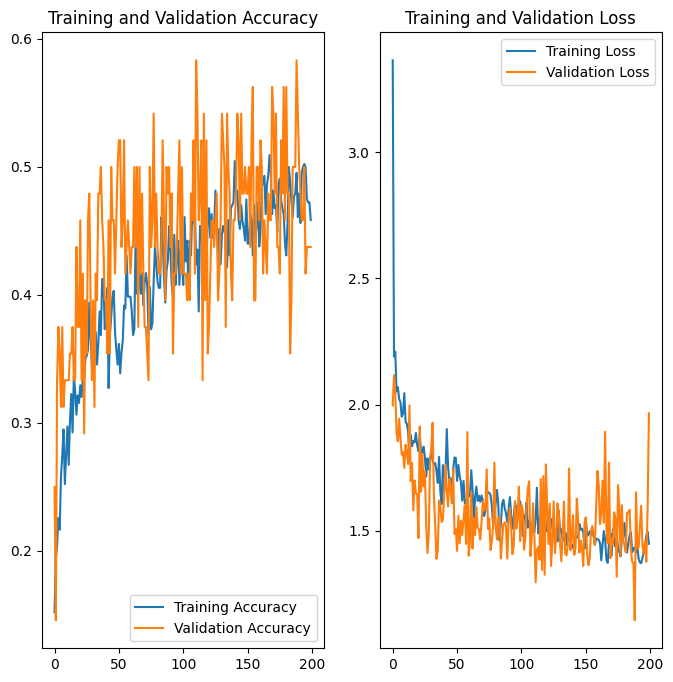

In [54]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

epochs_range = range(n_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's give it a shot with InceptionV3

In [55]:


train_generator_in = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                    # validation_split=0.15,
                                    # fill_mode = 'constant',
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator_in = ImageDataGenerator( preprocessing_function=preprocess_input) # VGG16 preprocessing


In [56]:
BATCH_SIZE=16

train_data_dir = 'skind_training'
test_data_dir = 'skind_validation'

traingen_in = train_generator_in.flow_from_directory(train_data_dir,
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               
                                               
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

testgen_in = train_generator_in.flow_from_directory(test_data_dir,
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)


Found 450 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [57]:
def create_model_in(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = InceptionV3(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer= optimizer, #RMSprop(lr=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [58]:
input_shape = (128, 128, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen_in.samples // BATCH_SIZE
n_test_steps = testgen_in.samples // BATCH_SIZE
n_epochs = 200


inc_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)
inc_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [59]:
inc_history = inc_model.fit(traingen_in,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=testgen_in,
                            steps_per_epoch=n_steps,
                            validation_steps=n_test_steps,
                            
                            verbose=1)

Epoch 1/200
28/28 [==============================] - 5s 122ms/step - loss: 3.2472 - accuracy: 0.1382 - val_loss: 2.0508 - val_accuracy: 0.2500
Epoch 2/200
28/28 [==============================] - 3s 115ms/step - loss: 2.1797 - accuracy: 0.1774 - val_loss: 2.0767 - val_accuracy: 0.2083
Epoch 3/200
28/28 [==============================] - 3s 115ms/step - loss: 2.1058 - accuracy: 0.2005 - val_loss: 1.9920 - val_accuracy: 0.2292
Epoch 4/200
28/28 [==============================] - 3s 115ms/step - loss: 2.0571 - accuracy: 0.2488 - val_loss: 1.9555 - val_accuracy: 0.2292
Epoch 5/200
28/28 [==============================] - 3s 115ms/step - loss: 2.1128 - accuracy: 0.2235 - val_loss: 1.8812 - val_accuracy: 0.3333
Epoch 6/200
28/28 [==============================] - 3s 115ms/step - loss: 2.0270 - accuracy: 0.2512 - val_loss: 1.8241 - val_accuracy: 0.3542
Epoch 7/200
28/28 [==============================] - 3s 117ms/step - loss: 1.9968 - accuracy: 0.2545 - val_loss: 1.8322 - val_accuracy: 0.2917

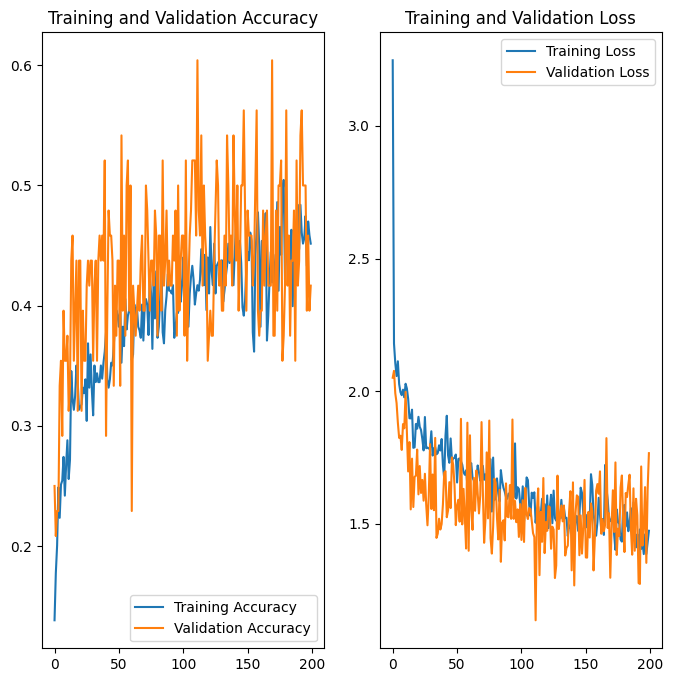

In [60]:
acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs_range = range(n_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notes for self: 

-batch size 8 only seems to help Alexnet with SGD (will change to Adam) 

-unfreezing too many conv layers doesn't help much 

-should try Adam across the board, releasing few conv layers with no imagenet weights

-probably best to keep batch size 16 across the board also 

-small batch size seems to hurt VGG and Inception